##Install dependencies

In [2]:
# Install required libraries (if not already installed)
!pip install -q umap-learn scikit-learn

##Import necessary module

In [3]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score

# Reproducibility
SEED = 1337
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


##Load and preprocess MNIST dataset

In [4]:
# Load raw MNIST (uint8, shape: (N,28,28))
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Add channel dim (H,W,1)
x_train = x_train[..., np.newaxis]
x_test  = x_test[..., np.newaxis]

IMG_SIZE = 224   # ResNet50 expects >= 197; 224 is standard
BATCH = 64       # reduce if you run OOM (try 32 or 16)

def preprocess_image(image):
    # image: uint8 [H,W,1] or [H,W,1] tensor
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.grayscale_to_rgb(image)           # -> (H,W,3)
    image = tf.cast(image, tf.float32)                 # keep pixel range 0-255
    image = preprocess_input(image)                    # ResNet50 preprocessing
    return image

def make_dataset(x, y, batch=BATCH, training=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if training:
        ds = ds.shuffle(10000, seed=SEED)
    ds = ds.map(lambda im, lab: (preprocess_image(im), lab), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(x_train, y_train, batch=BATCH, training=True)
test_ds  = make_dataset(x_test,  y_test,  batch=BATCH, training=False)

print("Train size:", x_train.shape[0], "Test size:", x_test.shape[0])


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Train size: 60000 Test size: 10000


##build two model **instances**

In [5]:
# Base for BEFORE feature extraction (frozen)
base_before = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_before.trainable = False
feat_before = layers.GlobalAveragePooling2D(name='gap_before')(base_before.output)
feature_extractor_before = Model(inputs=base_before.input, outputs=feat_before, name='feat_ext_before')
feature_extractor_before.summary()

# Base for training (we'll set trainable below in two-step fine-tuning)
base_train = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_train.output
x = layers.GlobalAveragePooling2D(name='gap')(x)           # give it a name to easily fetch later
predictions = layers.Dense(10, activation='softmax', name='pred')(x)
train_model = Model(inputs=base_train.input, outputs=predictions, name='vgg16_mnist')
train_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "feat_ext_before"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap_before                      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "vgg16_mnist"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (Dense)                    │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

## Extract features BEFORE fine-tuning (penultimate vector)

In [6]:
# Predict features on test set (this uses frozen ImageNet weights)
features_before = feature_extractor_before.predict(test_ds, verbose=1)  # shape (10000, D)
labels = y_test  # numpy array of length 10000

print("features_before shape:", features_before.shape)

157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 326ms/step
features_before shape: (10000, 512)


##Train VGG16 classifier on MNIST




In [ ]:
# Step 1: train only the dense head
for layer in base_train.layers:
    layer.trainable = False
train_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
train_model.fit(train_ds, validation_data=test_ds, epochs=10)

# Evaluate after head-only training (before transfer learning)
loss_before, acc_before = train_model.evaluate(test_ds, verbose=0)
print(f"Final test accuracy BEFORE transfer learning: {acc_before:.4f}")

# Step 2: fine-tune last few convolutional blocks
for layer in base_train.layers[-4:]:
    layer.trainable = True
train_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
train_model.fit(train_ds, validation_data=test_ds, epochs=10)

# Evaluate after fine-tuning (after transfer learning)
loss_after, acc_after = train_model.evaluate(test_ds, verbose=0)
print(f"Final test accuracy AFTER transfer learning: {acc_after:.4f}")


Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 366s 388ms/step - accuracy: 0.7835 - loss: 0.7679 - val_accuracy: 0.9630 - val_loss: 0.1278
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 368s 375ms/step - accuracy: 0.9676 - loss: 0.1159 - val_accuracy: 0.9694 - val_loss: 0.1038
Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 368s 384ms/step - accuracy: 0.9842 - loss: 0.0520 - val_accuracy: 0.9890 - val_loss: 0.0372
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 370s 378ms/step - accuracy: 0.9963 - loss: 0.0134 - val_accuracy: 0.9902 - val_loss: 0.0335


##Extract features after fine-tuning

In [8]:
# 🔎 Extract learned features after fine-tuning
feature_extractor_after = Model(inputs=train_model.input,
                                outputs=train_model.get_layer('gap').output,
                                name='feat_ext_after')
features_after = feature_extractor_after.predict(test_ds, verbose=1)

print("features_after shape:", features_after.shape)


157/157 ━━━━━━━━━━━━━━━━━━━━ 47s 295ms/step
features_after shape: (10000, 512)


##Dimensionality reduction helpers PCA & plotting utilities

In [9]:
def subsample(features, labels, n=3000, seed=SEED):
    if features.shape[0] <= n:
        return features, labels
    rng = np.random.RandomState(seed)
    idx = rng.choice(np.arange(features.shape[0]), size=n, replace=False)
    return features[idx], labels[idx]

def embed_and_plot(X, y, title, method='pca', subsample_n=None, savepath=None):
    if subsample_n is not None:
        Xr, yr = subsample(X, y, n=subsample_n)
    else:
        Xr, yr = X, y

    if method == 'pca':
        R = PCA(n_components=2, random_state=SEED).fit_transform(Xr)
    elif method == 'tsne':
        R = TSNE(n_components=2, random_state=SEED, init='pca', perplexity=30).fit_transform(Xr)
    elif method == 'umap':
        R = umap.UMAP(n_components=2, random_state=SEED).fit_transform(Xr)
    else:
        raise ValueError("Unknown method")

    plt.figure(figsize=(7,6))
    scatter = plt.scatter(R[:,0], R[:,1], c=yr, cmap='tab10', s=6, alpha=0.8)
    plt.title(f"{title} — {method.upper()}")
    plt.xlabel('Dim 1'); plt.ylabel('Dim 2')
    plt.colorbar(ticks=range(10), label='digit')
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    plt.show()

def compute_silhouette(X, y, method='pca', subsample_n=3000):
    Xr, yr = subsample(X, y, n=subsample_n)
    if method == 'pca':
        R = PCA(n_components=2, random_state=SEED).fit_transform(Xr)
    elif method == 'tsne':
        R = TSNE(n_components=2, random_state=SEED, init='pca', perplexity=30).fit_transform(Xr)
    elif method == 'umap':
        R = umap.UMAP(n_components=2, random_state=SEED).fit_transform(Xr)
    else:
        raise ValueError("Unknown method")
    s = silhouette_score(R, yr, metric='euclidean')
    return s

##Visualization (PCA, t-SNE, UMAP)

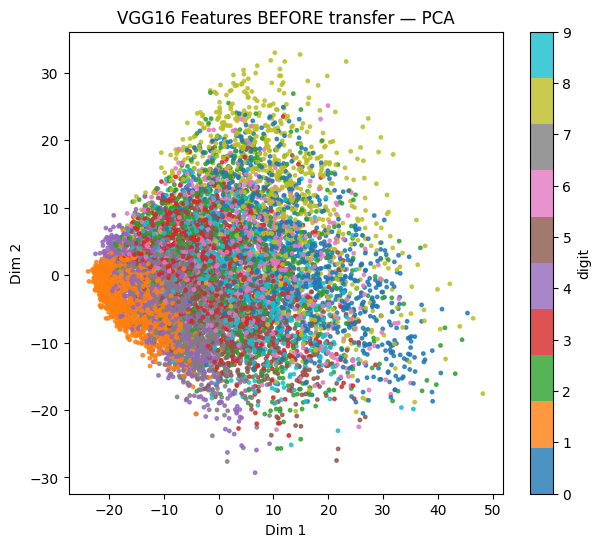

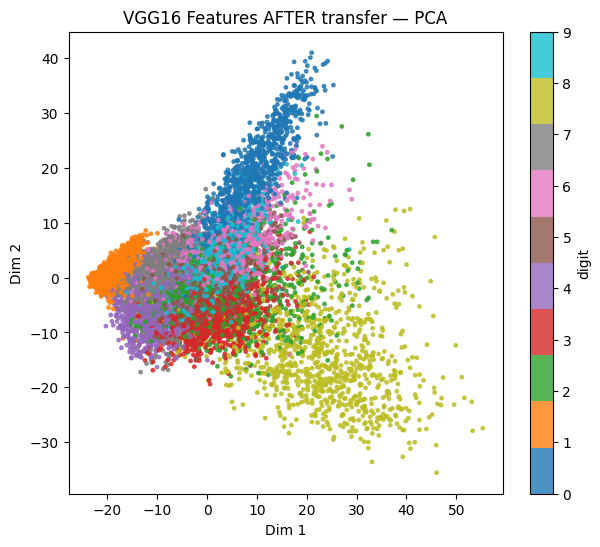

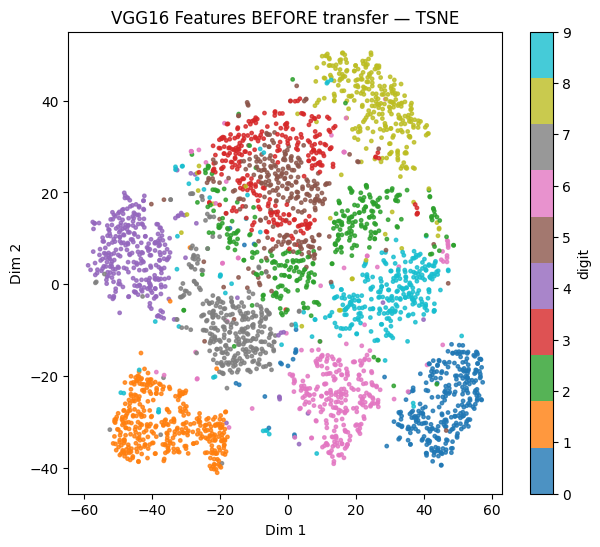

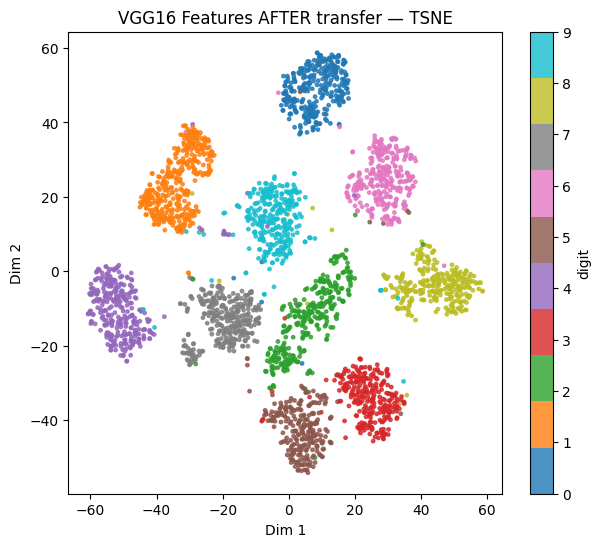

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


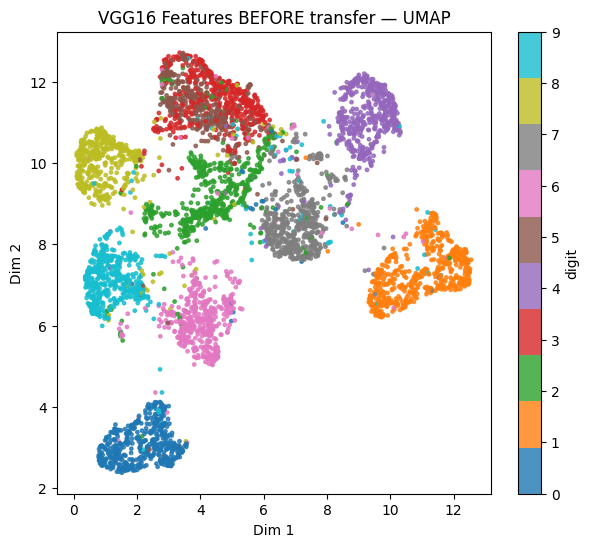

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


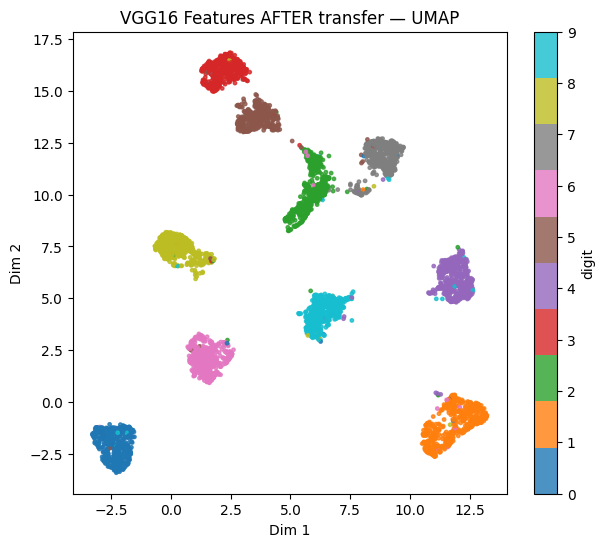

In [10]:
# Convert to numpy arrays (they already are numpy from predict)
Xb, yb = features_before, labels
Xa, ya = features_after, labels

# PCA (use all samples)
embed_and_plot(Xb, yb, "VGG16 Features BEFORE transfer", method='pca', subsample_n=None, savepath='before_pca.png')
embed_and_plot(Xa, ya, "VGG16 Features AFTER transfer",  method='pca', subsample_n=None, savepath='after_pca.png')

# t-SNE (subsample to speed up)
embed_and_plot(Xb, yb, "VGG16 Features BEFORE transfer", method='tsne', subsample_n=3000, savepath='before_tsne.png')
embed_and_plot(Xa, ya, "VGG16 Features AFTER transfer",  method='tsne', subsample_n=3000, savepath='after_tsne.png')

# UMAP (subsample optional)
embed_and_plot(Xb, yb, "VGG16 Features BEFORE transfer", method='umap', subsample_n=5000, savepath='before_umap.png')
embed_and_plot(Xa, ya, "VGG16 Features AFTER transfer",  method='umap', subsample_n=5000, savepath='after_umap.png')


##Silhouette score (before fine-tuning)


In [11]:
# 📏 Silhouette score for frozen VGG16 features
score_before = silhouette_score(features_before, labels)
print("Silhouette score (frozen VGG16 features):", score_before)


Silhouette score (frozen VGG16 features): 0.039744277


##Silhouette score (after fine-tuning)

In [12]:
# 📏 Silhouette score for fine-tuned VGG16 features
score_after = silhouette_score(features_after, labels)
print("Silhouette score (fine-tuned VGG16 features):", score_after)


Silhouette score (fine-tuned VGG16 features): 0.09725022
